In [0]:
import os
#os.chdir('/content/drive/My Drive/Colab Notebooks/Lazy courses/NLP2/pretrained_data')
os.chdir('/content/drive/My Drive/Colab Notebooks/Lazy courses/NLP2')

In [0]:
import json
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.utils import shuffle 
from utils import find_analogies

from utils import get_wikipedia_data
from brown import get_sentences_with_word2idx_limit_vocab, get_sentences_with_word2idx

In [0]:
#ALS minimizes two loss functions alternatively; 
#It first holds user matrix fixed and runs gradient descent with item matrix; 
#then it holds item matrix fixed and runs gradient descent with user matrix
#Using ALS whats the least number of files to get correct analogies

In [0]:
class Glove:
    def __init__(self, D, V, context_sz):
        self.D = D
        self.V = V
        self.context_sz = context_sz

    def fit(self, sentences, cc_matrix=None, learning_rate=1e-4, reg=0.1, xmax=100, alpha=0.75, epochs=10, gd=False):
        #build co-occurance matrix
        t0 = datetime.now()
        V = self.V
        D = self.D

        if not os.path.exists(cc_matrix):
            X = np.zeros((V, V))
            N = len(sentences)
            print("Number of senetences to process", N)
            it = 0

            for sentence in sentences:
                it += 1
                if it % 10000 == 0:
                    print(f"Processed {it} / {N}")
                n =len(sentence)
                for i in range(n):
                    #i points to which element of the sentence we are looking at
                    wi = sentence[i]

                    start = max(0, i - self.context_sz) 
                    end = min(n, i + self.context_sz)

                    #we can either choose only one side as context, or both
                    # Here we are choosing both
                    #we have to make sure 'start' and 'end' tokens are part of
                    #some context otherwise their f(X) will be 0 
                    #(denominator in bias update)

                    if i - self.context_sz < 0:
                        points = 1.0 / (i+1)
                        X[wi,0] += points
                        X[0,wi] += points

                    if i + self.context_sz > 0:
                        points = 1.0 / (n-i)
                        X[wi,1]  += points
                        X[1,wi] += points

                    #left side 
                    for j in range(start, i):
                        wj = sentence[j]
                        points = 1.0 / (i - j) #this is +ve
                        X[wi, wj] += points
                        X[wj, wi] += points
                    #right side    
                    for j in range(i+1, end):
                        wj = sentence[j]
                        points = 1.0 /(j - i) #this is +ve
                        X[wi, wj] += points
                        X[wj, wi] += points

            np.save(cc_matrix, X)
        else:
            X = np.load(cc_matrix)

        print("max in X", X.max())

        #weight normalization
        fX = np.zeros((V, V))
        fX[X < xmax] = (X[X < xmax] / float(xmax)) ** alpha
        fX[X >= xmax] = 1

        print("max in f(X)", fX.max())

        #target
        logX = np.log(X + 1)

        print("max in log(X):", logX.max())

        print("Building co-occurance matrix:", (datetime.now()- t0))

        #initialize weights
        W = np.random.randn(V, D) / np.sqrt(V + D)
        b = np.zeros(V)
        U = np.random.randn(V,D) / np.sqrt(V + D)
        c = np.zeros(V)
        mu = logX.mean()

        costs = []
        sentences_indexes = range(len(sentences))
        for epoch in range(epochs):
            delta = W.dot(U.T) + b.reshape(V, 1) + c.reshape(1, V) + mu - logX
            cost = ( fX * delta * delta).sum()
            costs.append(cost)
            print("Epoch:", epoch, "cost:", cost)

            if gd:
                #gradient descent method

                #update W
                for i in range(V):
                    # W[i] -= learning_rate*fX[i,j]*(W[i].dot(U[j]) + b[i] + c[j] + mu - logX[i,j])*U[j]
                    W -= learning_rate * (fX[i,:] * delta[i,:]).dot(U)
                W -= learning_rate*reg*W

                #update b
                for i in range(V):
                    # b[i] -= learning_rate*fX[i,j]*(W[i].dot(U[j]) + b[i] + c[j] + mu - logX[i,j])
                    b[i] -= learning_rate * fX[i,:].dot(delta[i,:])
                #b -= learning_rate * reg* W

                #update U
                for j in range(V):
                    # U[j] -= learning_rate*fX[i,j]*(W[i].dot(U[j]) + b[i] + c[j] + mu - logX[i,j])*W[i]
                    U[j]  -= learning_rate * (fX[:, j] * delta[:,j]).dot(W)
                U -= learning_rate * reg * U 

                #update c
                for j in range(V):
                    #  c[j] -= learning_rate*fX[i,j]*(W[i].dot(U[j]) + b[i] + c[j] + mu - logX[i,j])
                    c[j] -= learning_rate * fX[:,j].dot(delta[:, j])
                 # c -= learning_rate*reg*c

            else:
                #ALS method

                #update W
                
                t0 = datetime.now()

                for i in range(V):
                    #matrix = reg * np.eye(D) + (fX[i,:] * U.T).dot(U)
                    matrix = reg*np.eye(D) + (fX[i,:]*U.T).dot(U)
                    #vector = (fX[i,:] * logX[i,:] * U.T).dot(U)
                    vector = (fX[i,:]*(logX[i,:] - b[i] - c - mu)).dot(U)
                    W[i] = np.linalg.solve(matrix, vector)

                    #matrix = reg*np.eye(D) + (fX[i,:]*U.T).dot(U)
                    # assert(np.abs(matrix - matrix2).sum() < 1e-5)
                    #vector = (fX[i,:]*(logX[i,:] - b[i] - c - mu)).dot(U)

                print("ALS method took:", datetime.now() - t0)

                #update b
                for i in range(V):
                    denominator = fX[i, :].sum() + reg
                    numerator = fX[i,:].dot(logX[i,:] - W[i].dot(U.T) - c -mu)
                    b[i] = numerator / denominator

                #update U
                for j in range(V):
                    matrix = reg* np.eye(D) + (fX[:,j] * W.T).dot(W)
                    vector = (fX[:, j] * (logX[:,j] - b - c[j] - mu))

                #update c
                for j in range(V):
                    denominator = fX[:, j].sum() + reg
                    numerator = fX[:, j].dot(logX[:,j]- W.dot(U[j]) - b - mu)
                    c[j] = numerator / denominator


        self.W = W
        self.U = U

        plt.plot(costs)
        plt.show()

    
    def save(self, fn):
        #function word analogies expect a (V,D) matrix and a (D,V) matrix
        arrays = [self.W, self.U.T]
        np.savez(fn, *arrays)

In [0]:
def main(we_file, w2i_file, use_brown=True, n_files=100):
    if use_brown:
        cc_matrix = "cc_matrix_brown.npy"
    else:
        cc_matrix = "cc_matrix_%s.npy" % n_files

    #same old way of checking if we need to re-load the raw data or not
    #remember, only the co-occurence matrix is needed for training

    if os.path.exists(cc_matrix):
        with open(w2i) as f:
            word2idx = json.load(f)
        sentences = [] #dummy list, we wont actually use it

    else:
        if use_brown:
            keep_words = set([
                'king', 'man', 'woman',
                'france', 'paris', 'london', 'rome', 'italy', 'britain', 'england',
                'french', 'english', 'japan', 'japanese', 'chinese', 'italian',
                'australia', 'australian', 'december', 'november', 'june',
                'january', 'february', 'march', 'april', 'may', 'july', 'august',
                'september', 'october',
            ])

            sentences, word2idx = get_sentences_with_word2idx_limit_vocab(n_vocab=5000, keep_words=keep_words)

        else:
            sentences, word2idx = get_wikipedia_data(n_files = n_files, n_vocab = 2000)

        with open(w2i_file, 'w') as f:
            json.dump(word2idx, f)

    V = len(word2idx)
    model = Glove(100, V, 10)

    #alternating least square method
    model.fit(sentences, cc_matrix=cc_matrix, epochs=20)

    #gradient descent method
    #model.fit(sentences, cc_matrix=cc_matrix. learning_rate=5e-4, reg=0.1epochs=500, gd=True)
    
    model.save(we_file)

max in X 75446433.19263569
max in f(X) 1.0
max in log(X): 18.138933481526337
Building co-occurance matrix: 0:00:00.613202
Epoch: 0 cost: 5754260.947194482
ALS method took: 0:00:05.800280
Epoch: 1 cost: 851242.7041293962
ALS method took: 0:00:05.758970
Epoch: 2 cost: 754680.8432139151
ALS method took: 0:00:05.721754
Epoch: 3 cost: 746705.265816185
ALS method took: 0:00:05.722831
Epoch: 4 cost: 745562.1915970909
ALS method took: 0:00:05.725532
Epoch: 5 cost: 745232.973645697
ALS method took: 0:00:05.716624
Epoch: 6 cost: 745089.2347541997
ALS method took: 0:00:05.778286
Epoch: 7 cost: 745018.9500983905
ALS method took: 0:00:05.738253
Epoch: 8 cost: 744984.6045371497
ALS method took: 0:00:05.718889
Epoch: 9 cost: 744968.6117581232
ALS method took: 0:00:05.725586
Epoch: 10 cost: 744961.9516388458
ALS method took: 0:00:05.734137
Epoch: 11 cost: 744959.9181045637
ALS method took: 0:00:05.777116
Epoch: 12 cost: 744960.0612955366
ALS method took: 0:00:05.765167
Epoch: 13 cost: 744961.122485080

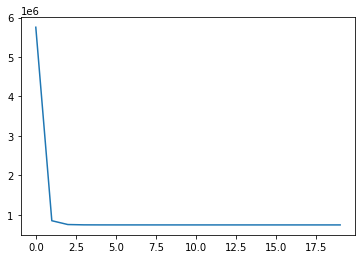

** concat: True
Closest match by euclidean distance: ii
king - man = ii - woman
Closest match by cosine distance: louis
king - man = louis - woman
Closest match by euclidean distance: kingdom
france - paris = kingdom - london
Closest match by cosine distance: kingdom
france - paris = kingdom - london
Closest match by euclidean distance: spain
france - paris = spain - rome
Closest match by cosine distance: spain
france - paris = spain - rome
Closest match by euclidean distance: london
paris - france = london - italy
Closest match by cosine distance: london
paris - france = london - italy
Closest match by euclidean distance: england
france - french = england - english
Closest match by cosine distance: england
france - french = england - english
Closest match by euclidean distance: india
japan - japanese = india - chinese
Closest match by cosine distance: india
japan - japanese = india - chinese
Closest match by euclidean distance: india
japan - japanese = india - italian
Closest match by

In [0]:
if __name__ == '__main__':
    we = 'glove_model_50.npz'
    w2i = 'glove_word2idx_50.json'
    # we = 'glove_model_brown.npz'
    # w2i = 'glove_word2idx_brown.json'

    main(we, w2i, use_brown=False)

    #load back embeddings
    npz = np.load(we)
    W1 = npz['arr_0']
    W2 = npz['arr_1']

    with open(w2i) as f:
        word2idx = json.load(f)
        idx2word = {i:w for w,i in word2idx.items()}

    for concat in (True, False):
        print("** concat:", concat)

        if concat:
            We = np.hstack([W1, W2.T])
        else:
            We = (W1 + W2.T) / 2

        
        find_analogies('king', 'man', 'woman', We, word2idx, idx2word)
        find_analogies('france', 'paris', 'london', We, word2idx, idx2word)
        find_analogies('france', 'paris', 'rome', We, word2idx, idx2word)
        find_analogies('paris', 'france', 'italy', We, word2idx, idx2word)
        find_analogies('france', 'french', 'english', We, word2idx, idx2word)
        find_analogies('japan', 'japanese', 'chinese', We, word2idx, idx2word)
        find_analogies('japan', 'japanese', 'italian', We, word2idx, idx2word)
        find_analogies('japan', 'japanese', 'australian', We, word2idx, idx2word)
        find_analogies('december', 'november', 'june', We, word2idx, idx2word)
